In [1]:
%pip install \
    pandas==2.2.2 \
    tensorflow==2.16.1 \
    keras==3.3.3 \
    matplotlib==3.9.0 \
    imbalanced-learn==0.12.3 \
    scikit-learn==1.5.0 \
    pydot==2.0.0 \
    pydot-ng==2.0.0 \
    graphviz==0.20.3 \
    plot_model==0.20 --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

pd.set_option("display.max_rows", None)

In [3]:
# Read in the csv data using pandas 
train = pd.read_csv("./data/train.csv", index_col=0)

The first thing to do is take a look at what types of data we have to train with. Categorical features can be handled via [embedding](https://www.fast.ai/2018/04/29/categorical-embeddings/).

In [4]:
train.dtypes.value_counts()

int64      259
float64    111
Name: count, dtype: int64

There are no columns with string datatype, so we shall not be using the aforementioned embedding. However, we do have a large number of integer columns. Let us take a look at how many different values each of these integer columns have.

In [5]:
train.select_dtypes(include=["int64"]).nunique()

var3                             208
var15                            100
ind_var1_0                         2
ind_var1                           2
ind_var2_0                         1
ind_var2                           1
ind_var5_0                         2
ind_var5                           2
ind_var6_0                         2
ind_var6                           2
ind_var8_0                         2
ind_var8                           2
ind_var12_0                        2
ind_var12                          2
ind_var13_0                        2
ind_var13_corto_0                  2
ind_var13_corto                    2
ind_var13_largo_0                  2
ind_var13_largo                    2
ind_var13_medio_0                  2
ind_var13_medio                    2
ind_var13                          2
ind_var14_0                        2
ind_var14                          2
ind_var17_0                        2
ind_var17                          2
ind_var18_0                        2
i

Many of the integer features in our dataset have a single unique value, resulting in zero variance. Since these columns do not contribute to the predictive power of the model, we will remove them from both the training and test datasets to maintain consistency.

In [6]:
features_to_drop = train.nunique()

features_to_drop = features_to_drop.loc[features_to_drop.values==1].index
print(features_to_drop)

# Drop these columns from both the training and the test datasets
train = train.drop(features_to_drop,axis=1)

Index(['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28',
       'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0',
       'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0',
       'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46',
       'imp_amort_var18_hace3', 'imp_amort_var34_hace3',
       'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3',
       'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3',
       'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3',
       'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3',
       'num_trasp_var33_out_hace3', 'saldo_var2_ult1',
       'saldo_medio_var13_medio_hace3'],
      dtype='object')


Next, we will check for any missing values in the dataset, as neural networks do not handle missing data well.

In [7]:
train.isnull().values.any()

False

Great, there are no missing values in the dataset. Now, let's proceed by splitting the training data into features and target variables.

In [8]:
X = train.iloc[:,:-1]
y = train["TARGET"]

Check to see whether the data is [highly imbalanced or not](https://www.kaggle.com/carlmcbrideellis/classification-how-imbalanced-is-imbalanced)

In [9]:
y.value_counts().to_frame().T

TARGET,0,1
count,73012,3008


Indeed, there is a significant class imbalance in the dataset. To address this, we will resample the minority class using [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (Synthetic Minority Over-sampling Technique) from the [imbalanced-learn](https://imbalanced-learn.org/stable/) library.

In [10]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

Let us take a look.

In [11]:
y_resampled.value_counts().to_frame().T

TARGET,0,1
count,73012,73012


Since this is a large dataset, we will use only 50% of the data for training and 20% for validation.

In [12]:
from sklearn.model_selection import train_test_split

# Splitting into train (50%), validation (20%), and test (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, 
                                                   train_size=0.5,
                                                   test_size=0.5, 
                                                   random_state=42, 
                                                   shuffle=True)

# Further splitting temp into validation (40%) and test (60%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                               test_size=0.6, 
                                               random_state=42, 
                                               shuffle=True)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (73012, 335)
X_val shape: (29204, 335)
X_test shape: (43808, 335)
y_train shape: (73012,)
y_val shape: (29204,)
y_test shape: (43808,)


Additionally, neural networks perform better when the data is within the same range, such as [0,1], to improve stability. We will achieve this using the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). 

**Note:** It is important to remove any outliers before applying this scaling, as a single outlier can significantly influence the results.

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

We are now ready to create our neural network. Note that we will include a [dropout layer](https://keras.io/api/layers/regularization_layers/dropout/) as a form of regularization. This layer helps reduce overfitting by randomly setting 30% of the input unit values to zero.

In [14]:
model = keras.Sequential(
    [
        keras.layers.Dense(units=9, activation="relu", input_shape=(X_train.shape[-1],) ),
        # Randomly delete 30% of the input units below
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=9, activation="relu"),
        # The output layer, with a single neuron
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

# Save the initial weights for later
initial_weights = model.get_weights()

/Users/vaibhavsethia07/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let us take a look at the model.

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 9)              │         3,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,124 (12.20 KB)

 Trainable params: 3,124 (12.20 KB)

 Non-trainable params: 0 (0.00 B)

A more aesthetically pleasing representation

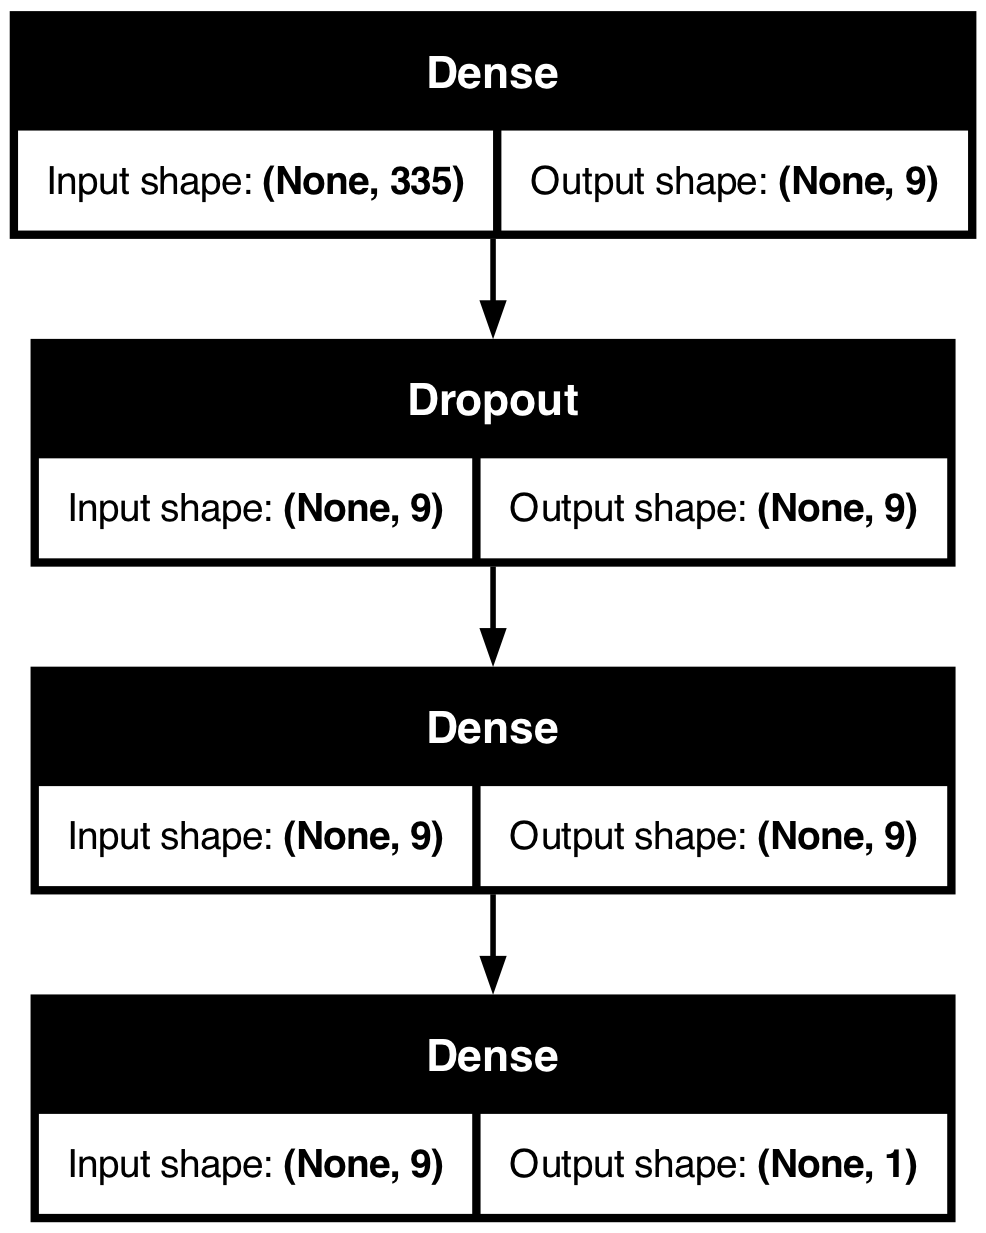

In [16]:
keras.utils.plot_model(model, show_shapes=True)

We will utilize the [Adam optimizer](https://keras.io/api/optimizers/adam/), a variant of [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD).

Given that our problem involves binary classification, our [loss function](https://en.wikipedia.org/wiki/Loss_function) will be [binary cross entropy](https://keras.io/api/losses/probabilistic_losses/). Lastly, we will assess model performance using the area under the curve (AUC) of the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

This setup aligns our model training with standard practices in binary classification tasks, optimizing for AUC-ROC as a primary metric.

In [17]:
learning_rate = 0.001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="binary_crossentropy", 
              metrics=[keras.metrics.AUC()])

We will proceed to train the model using a `batch_size` of 1000 rows of training data at a time, and repeat the process for 500 `epochs`.

The `batch_size` impacts the rate at which the neural network converges; larger sizes may require more `epochs` for convergence.

This approach ensures systematic training over multiple epochs, optimizing model performance while managing computational resources effectively.

In [18]:
history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=1000, 
          validation_data=(X_val, y_val),
          verbose=0)

Examine the training process to assess for signs of overfitting or underfitting, visualizing the learning curves for insights.

In [19]:
logs = pd.DataFrame(history.history)

print(logs)

          auc      loss   val_auc  val_loss
0    0.718200  0.636766  0.801519  0.565983
1    0.786775  0.557906  0.835917  0.516466
2    0.813762  0.522568  0.857461  0.487817
3    0.833215  0.499615  0.869308  0.469775
4    0.850181  0.482649  0.877049  0.454777
5    0.861581  0.468169  0.882902  0.440381
6    0.870786  0.454827  0.887875  0.429713
7    0.875591  0.446963  0.891151  0.421928
8    0.879586  0.439722  0.893149  0.415556
9    0.881989  0.434622  0.895254  0.410268
10   0.885425  0.428673  0.897347  0.405768
11   0.887755  0.424411  0.899506  0.403641
12   0.891431  0.417712  0.900577  0.400174
13   0.890946  0.418990  0.902007  0.397263
14   0.893622  0.413176  0.904129  0.392977
15   0.894844  0.410700  0.904839  0.390622
16   0.896470  0.407688  0.905209  0.388925
17   0.897154  0.405643  0.907286  0.385356
18   0.897718  0.405240  0.907706  0.386153
19   0.898911  0.402633  0.909104  0.382419
20   0.899699  0.400835  0.909478  0.380300
21   0.900630  0.398433  0.91038

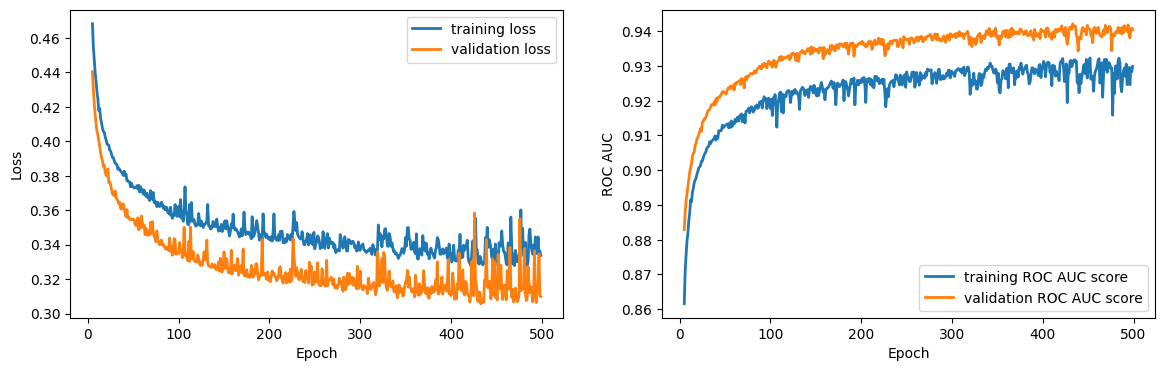

In [20]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label="training loss")
plt.plot(logs.loc[5:,"val_loss"], lw=2, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label="training ROC AUC score")
plt.plot(logs.loc[5:,"val_auc"], lw=2, label="validation ROC AUC score")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc="lower right")
plt.show()

Towards the end of training, observe that the validation ROC AUC score has plateaued without further improvement. Additionally, despite the validation ROC AUC score stabilizing, the training ROC AUC score continues to increase steadily, signaling potential overfitting. It's crucial to monitor these trends to optimize training efficiency and avoid unnecessary consumption of CPU/GPU resources. To achieve this, we can implement a "callback":

In [21]:
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore

early_stopping = EarlyStopping(
    min_delta = 0.0002, # Minimium amount of change to count as an improvement
    patience  = 20,     # How many epochs to wait before stopping
    restore_best_weights=True)

Let's reset our training process by reverting to the initial weights of our neural network and starting afresh.

In [22]:
model.set_weights(initial_weights)

In [23]:
history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=1000, 
          validation_data=(X_val, y_val),
          verbose=0,
          # Add in early stopping callback
          callbacks=[early_stopping]
        )

In [24]:
logs = pd.DataFrame(history.history)
print(logs)

          auc      loss   val_auc  val_loss
0    0.692104  0.651007  0.779972  0.588228
1    0.766885  0.577142  0.813433  0.536024
2    0.788207  0.550533  0.843088  0.518762
3    0.800558  0.537920  0.858264  0.507719
4    0.807910  0.530118  0.862275  0.499463
5    0.812230  0.522937  0.866402  0.492716
6    0.819725  0.513790  0.869586  0.485000
7    0.825823  0.505291  0.871483  0.478296
8    0.830823  0.499645  0.873514  0.472565
9    0.837242  0.491712  0.876181  0.466451
10   0.841774  0.486958  0.878568  0.460713
11   0.848406  0.479732  0.881019  0.453671
12   0.853404  0.473706  0.882257  0.449467
13   0.856821  0.469834  0.884311  0.444435
14   0.860687  0.464746  0.886125  0.438731
15   0.862660  0.462130  0.887907  0.435107
16   0.866649  0.456967  0.889672  0.431047
17   0.868807  0.453121  0.891820  0.427571
18   0.872621  0.447443  0.894240  0.422134
19   0.874773  0.443931  0.895244  0.416468
20   0.877858  0.439363  0.896932  0.412654
21   0.879522  0.436398  0.89869

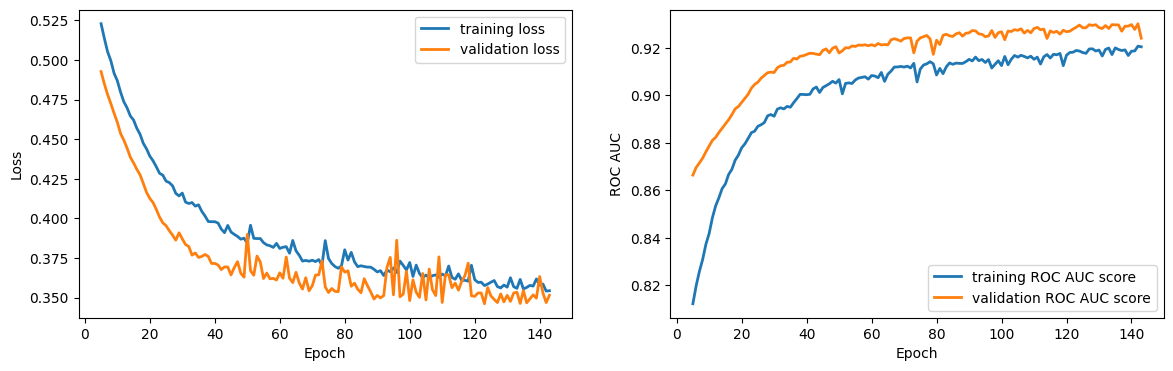

In [25]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label="training loss")
plt.plot(logs.loc[5:,"val_loss"], lw=2, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label="training ROC AUC score")
plt.plot(logs.loc[5:,"val_auc"], lw=2, label="validation ROC AUC score")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc="lower right")
plt.show()

Having completed the training of our neural network, we will now apply our model to the `test` data for inference.

In [26]:
from sklearn import metrics

predictions = model.predict(X_test)
binary_predictions = (predictions >= 0.5).astype(int)

accuracy = metrics.accuracy_score(y_test, binary_predictions)
print(f"accuracy = {accuracy}")

avg_precision_score = metrics.average_precision_score(y_test, binary_predictions)
print(f"average precision score = {avg_precision_score}")

report = metrics.classification_report(y_test, binary_predictions)
print(report)

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
accuracy = 0.8553917092768444
average precision score = 0.8024226205290068
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     21914
           1       0.85      0.86      0.86     21894

    accuracy                           0.86     43808
   macro avg       0.86      0.86      0.86     43808
weighted avg       0.86      0.86      0.86     43808



# Conclusion

The model achieved an accuracy of approximately 85% on the test set, indicating that it correctly classified a significant majority of the test instances. Additionally, the average precision score of approx 0.80 reflects the model's ability to distinguish between the positive and negative classes effectively, particularly in terms of precision-recall balance. These results suggest that the model is well-suited for the binary classification task and provides a good balance between precision and recall, making it a reliable predictor for the given problem.
